In [89]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models, datasets
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import re


train_dir = "/kaggle/input/butterflies/train_butterflies/"
test_dir = "/kaggle/input/butterflies/test_butterflies/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [90]:
# предварительное исследование
classes = sorted([d for d in os.listdir(train_dir)])
# print(classes)

total = 0
balance_ = dict()
resolutions = set()

for class_ in classes:
    class_path = os.path.join(train_dir, class_)
    balance_[class_] = 0
    class_images = [_ for _ in os.listdir(class_path)]

    for image in class_images:
        img_path = os.path.join(class_path, image)
        total += 1
        balance_[class_] += 1
        with Image.open(img_path) as img:
            width, height = img.size
            resolutions.add((width, height))

balance = sorted(balance_.items(), key=lambda item: item[1])
print("Всего изображений", total) # 4955
print("Разрешение:", resolutions) # 224 * 224 

Всего изображений 4955
Разрешение: {(224, 224)}


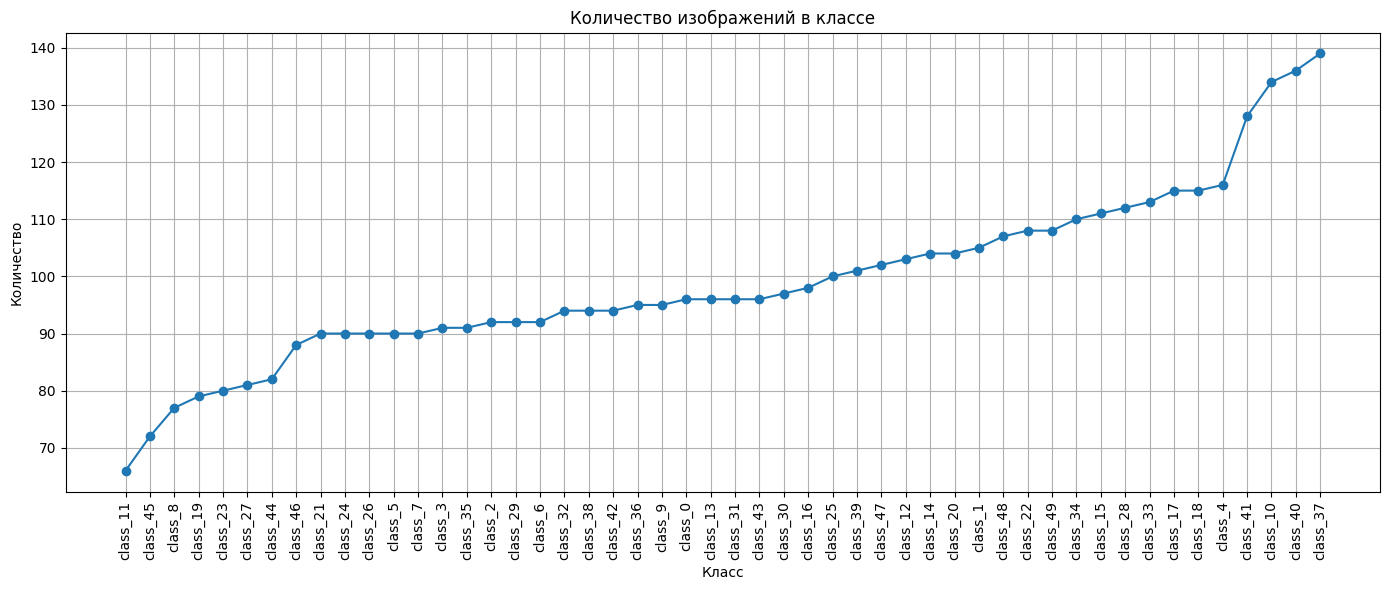

In [91]:
import matplotlib.pyplot as plt

classes = [item[0] for item in balance]
values = [item[1] for item in balance]

plt.figure(figsize=(14, 6))
plt.plot(classes, values, marker='o')
plt.xticks(rotation=90)
plt.title('Количество изображений в классе')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
# функция для рисования кривых обучения
def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(train_loss, label='Train Loss', linewidth=2)
    axes[0].plot(val_loss, label='Val Loss', linewidth=2)
    axes[0].set_title('Loss per Epoch', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(loc='upper right', fontsize=10)

    axes[1].plot(train_acc, label='Train Accuracy', linewidth=2)
    axes[1].plot(val_acc, label='Val Accuracy', linewidth=2)
    axes[1].set_title('Accuracy per Epoch', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(loc='lower right', fontsize=10)

    plt.show()

In [93]:
# подготовка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # статистика ImageNet
])

train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

train_ds, val_ds = random_split(train_dataset, [0.8, 0.2])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [94]:
# датасет для тестовых данных
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = sorted(
            [os.path.join(root_dir, f) for f in os.listdir(root_dir)],
            key=lambda x: int(re.search(r'(\d+)', os.path.basename(x)).group(1)) # регулярка находит число в имени файла
        )

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)

    def __len__(self):
        return len(self.image_files)

test_dataset = TestDataset(root_dir=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [95]:
# первая модель - попытка натренировать с нуля
class BasicBlock1(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )
        self.skip = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride=2, bias=False),
            nn.BatchNorm2d(128)
        )

    def forward(self, x):
        return (self.skip(x) + self.block(x)).relu()
    
class BasicBlock2(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )

    def forward(self, x):
        return (x + self.block(x)).relu()

model = nn.Sequential( # попробуем обучить не слишком глубокую сеть
    nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.MaxPool2d((3,3), stride=2, padding=1),
    BasicBlock1(),
    BasicBlock2(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(128, 50)
).to(device)


In [96]:
# функция обучения модели
def train_model(model, num_epochs, optimizer, criterion, name, scheduler=None):
    max_acc = 0
    
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    
    for epoch in range(num_epochs):
        # тренировка
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        train_loss /= len(train_loader)
        
        # валидация
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        val_loss /= len(val_loader)

        if scheduler is not None:
            scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")
    
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
    
        if max_acc < val_acc:
            max_acc = val_acc
            torch.save(model.state_dict(), name)

    plot_training_curves(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

Epoch 1/50: 100%|██████████| 248/248 [00:11<00:00, 21.58it/s]


Train Loss: 3.1786 | Acc: 17.15%
Val Loss: 2.7191 | Acc: 27.95%


Epoch 2/50: 100%|██████████| 248/248 [00:11<00:00, 21.40it/s]


Train Loss: 2.6288 | Acc: 27.77%
Val Loss: 2.4252 | Acc: 31.89%


Epoch 3/50: 100%|██████████| 248/248 [00:11<00:00, 21.24it/s]


Train Loss: 2.3613 | Acc: 35.65%
Val Loss: 2.3366 | Acc: 36.33%


Epoch 4/50: 100%|██████████| 248/248 [00:11<00:00, 21.20it/s]


Train Loss: 2.1683 | Acc: 39.58%
Val Loss: 2.2558 | Acc: 37.03%


Epoch 5/50: 100%|██████████| 248/248 [00:11<00:00, 21.30it/s]


Train Loss: 1.9978 | Acc: 44.60%
Val Loss: 1.9736 | Acc: 44.60%


Epoch 6/50: 100%|██████████| 248/248 [00:10<00:00, 22.60it/s]


Train Loss: 1.8286 | Acc: 49.45%
Val Loss: 1.9086 | Acc: 47.12%


Epoch 7/50: 100%|██████████| 248/248 [00:11<00:00, 22.07it/s]


Train Loss: 1.7259 | Acc: 52.70%
Val Loss: 1.8240 | Acc: 49.55%


Epoch 8/50: 100%|██████████| 248/248 [00:11<00:00, 22.04it/s]


Train Loss: 1.5988 | Acc: 55.73%
Val Loss: 1.9172 | Acc: 44.40%


Epoch 9/50: 100%|██████████| 248/248 [00:11<00:00, 21.97it/s]


Train Loss: 1.5186 | Acc: 57.09%
Val Loss: 1.5989 | Acc: 53.99%


Epoch 10/50: 100%|██████████| 248/248 [00:11<00:00, 22.35it/s]


Train Loss: 1.3947 | Acc: 61.00%
Val Loss: 1.8072 | Acc: 50.15%


Epoch 11/50: 100%|██████████| 248/248 [00:11<00:00, 22.24it/s]


Train Loss: 1.3377 | Acc: 62.11%
Val Loss: 1.5324 | Acc: 59.43%


Epoch 12/50: 100%|██████████| 248/248 [00:11<00:00, 22.04it/s]


Train Loss: 1.2692 | Acc: 64.86%
Val Loss: 1.3967 | Acc: 58.43%


Epoch 13/50: 100%|██████████| 248/248 [00:11<00:00, 22.12it/s]


Train Loss: 1.2132 | Acc: 65.69%
Val Loss: 1.3766 | Acc: 61.76%


Epoch 14/50: 100%|██████████| 248/248 [00:11<00:00, 21.70it/s]


Train Loss: 1.1354 | Acc: 67.71%
Val Loss: 1.3415 | Acc: 61.05%


Epoch 15/50: 100%|██████████| 248/248 [00:10<00:00, 22.56it/s]


Train Loss: 1.1142 | Acc: 68.11%
Val Loss: 1.1563 | Acc: 66.20%


Epoch 16/50: 100%|██████████| 248/248 [00:11<00:00, 21.39it/s]


Train Loss: 1.0346 | Acc: 71.14%
Val Loss: 1.3099 | Acc: 62.46%


Epoch 17/50: 100%|██████████| 248/248 [00:11<00:00, 21.34it/s]


Train Loss: 1.0139 | Acc: 71.37%
Val Loss: 1.3469 | Acc: 58.83%


Epoch 18/50: 100%|██████████| 248/248 [00:11<00:00, 21.48it/s]


Train Loss: 0.9709 | Acc: 73.36%
Val Loss: 1.1715 | Acc: 65.79%


Epoch 19/50: 100%|██████████| 248/248 [00:11<00:00, 21.62it/s]


Train Loss: 0.9317 | Acc: 73.69%
Val Loss: 1.4785 | Acc: 56.71%


Epoch 20/50: 100%|██████████| 248/248 [00:11<00:00, 21.63it/s]


Train Loss: 0.9043 | Acc: 74.45%
Val Loss: 1.3268 | Acc: 62.56%


Epoch 21/50: 100%|██████████| 248/248 [00:11<00:00, 21.40it/s]


Train Loss: 0.8700 | Acc: 75.40%
Val Loss: 1.2474 | Acc: 63.47%


Epoch 22/50: 100%|██████████| 248/248 [00:11<00:00, 21.09it/s]


Train Loss: 0.8680 | Acc: 75.45%
Val Loss: 1.3278 | Acc: 60.65%


Epoch 23/50: 100%|██████████| 248/248 [00:11<00:00, 21.87it/s]


Train Loss: 0.8090 | Acc: 77.02%
Val Loss: 1.3604 | Acc: 62.66%


Epoch 24/50: 100%|██████████| 248/248 [00:11<00:00, 22.17it/s]


Train Loss: 0.7796 | Acc: 77.55%
Val Loss: 1.0061 | Acc: 70.74%


Epoch 25/50: 100%|██████████| 248/248 [00:11<00:00, 21.30it/s]


Train Loss: 0.7461 | Acc: 78.73%
Val Loss: 1.0661 | Acc: 68.62%


Epoch 26/50: 100%|██████████| 248/248 [00:11<00:00, 21.63it/s]


Train Loss: 0.7294 | Acc: 79.36%
Val Loss: 1.0170 | Acc: 69.32%


Epoch 27/50: 100%|██████████| 248/248 [00:11<00:00, 21.86it/s]


Train Loss: 0.7125 | Acc: 79.97%
Val Loss: 1.1633 | Acc: 66.30%


Epoch 28/50: 100%|██████████| 248/248 [00:11<00:00, 21.99it/s]


Train Loss: 0.6976 | Acc: 81.03%
Val Loss: 0.9565 | Acc: 71.75%


Epoch 29/50: 100%|██████████| 248/248 [00:11<00:00, 20.93it/s]


Train Loss: 0.6711 | Acc: 81.21%
Val Loss: 0.8909 | Acc: 74.57%


Epoch 30/50: 100%|██████████| 248/248 [00:11<00:00, 21.14it/s]


Train Loss: 0.6705 | Acc: 81.31%
Val Loss: 0.9737 | Acc: 71.14%


Epoch 31/50: 100%|██████████| 248/248 [00:11<00:00, 21.96it/s]


Train Loss: 0.6191 | Acc: 83.20%
Val Loss: 0.8831 | Acc: 74.37%


Epoch 32/50: 100%|██████████| 248/248 [00:11<00:00, 22.35it/s]


Train Loss: 0.6011 | Acc: 83.60%
Val Loss: 0.9140 | Acc: 72.75%


Epoch 33/50: 100%|██████████| 248/248 [00:11<00:00, 21.63it/s]


Train Loss: 0.6217 | Acc: 82.21%
Val Loss: 1.2094 | Acc: 64.88%


Epoch 34/50: 100%|██████████| 248/248 [00:11<00:00, 21.66it/s]


Train Loss: 0.5830 | Acc: 84.26%
Val Loss: 0.9069 | Acc: 77.80%


Epoch 35/50: 100%|██████████| 248/248 [00:11<00:00, 21.74it/s]


Train Loss: 0.5717 | Acc: 84.46%
Val Loss: 0.8793 | Acc: 75.68%


Epoch 36/50: 100%|██████████| 248/248 [00:11<00:00, 22.09it/s]


Train Loss: 0.5593 | Acc: 84.76%
Val Loss: 0.8563 | Acc: 74.17%


Epoch 37/50: 100%|██████████| 248/248 [00:11<00:00, 21.67it/s]


Train Loss: 0.5348 | Acc: 84.86%
Val Loss: 1.0586 | Acc: 68.01%


Epoch 38/50: 100%|██████████| 248/248 [00:11<00:00, 20.82it/s]


Train Loss: 0.5593 | Acc: 84.13%
Val Loss: 0.9343 | Acc: 73.26%


Epoch 39/50: 100%|██████████| 248/248 [00:11<00:00, 21.33it/s]


Train Loss: 0.5147 | Acc: 86.20%
Val Loss: 0.9927 | Acc: 72.65%


Epoch 40/50: 100%|██████████| 248/248 [00:11<00:00, 20.95it/s]


Train Loss: 0.5081 | Acc: 86.35%
Val Loss: 0.8835 | Acc: 75.48%


Epoch 41/50: 100%|██████████| 248/248 [00:11<00:00, 22.09it/s]


Train Loss: 0.5009 | Acc: 85.90%
Val Loss: 0.8421 | Acc: 75.78%


Epoch 42/50: 100%|██████████| 248/248 [00:11<00:00, 21.92it/s]


Train Loss: 0.4947 | Acc: 85.97%
Val Loss: 0.9179 | Acc: 73.46%


Epoch 43/50: 100%|██████████| 248/248 [00:11<00:00, 21.83it/s]


Train Loss: 0.4848 | Acc: 87.11%
Val Loss: 1.1336 | Acc: 68.21%


Epoch 44/50: 100%|██████████| 248/248 [00:11<00:00, 21.31it/s]


Train Loss: 0.4687 | Acc: 87.34%
Val Loss: 0.8120 | Acc: 76.79%


Epoch 45/50: 100%|██████████| 248/248 [00:11<00:00, 21.79it/s]


Train Loss: 0.4509 | Acc: 87.66%
Val Loss: 0.8162 | Acc: 78.81%


Epoch 46/50: 100%|██████████| 248/248 [00:11<00:00, 21.12it/s]


Train Loss: 0.4392 | Acc: 87.92%
Val Loss: 0.7346 | Acc: 78.61%


Epoch 47/50: 100%|██████████| 248/248 [00:11<00:00, 21.19it/s]


Train Loss: 0.4344 | Acc: 88.75%
Val Loss: 0.7529 | Acc: 79.82%


Epoch 48/50: 100%|██████████| 248/248 [00:11<00:00, 21.43it/s]


Train Loss: 0.4488 | Acc: 87.76%
Val Loss: 1.2631 | Acc: 65.79%


Epoch 49/50: 100%|██████████| 248/248 [00:11<00:00, 22.10it/s]


Train Loss: 0.4240 | Acc: 88.29%
Val Loss: 1.4679 | Acc: 60.34%


Epoch 50/50: 100%|██████████| 248/248 [00:11<00:00, 21.79it/s]


Train Loss: 0.4226 | Acc: 88.47%
Val Loss: 1.1014 | Acc: 70.64%


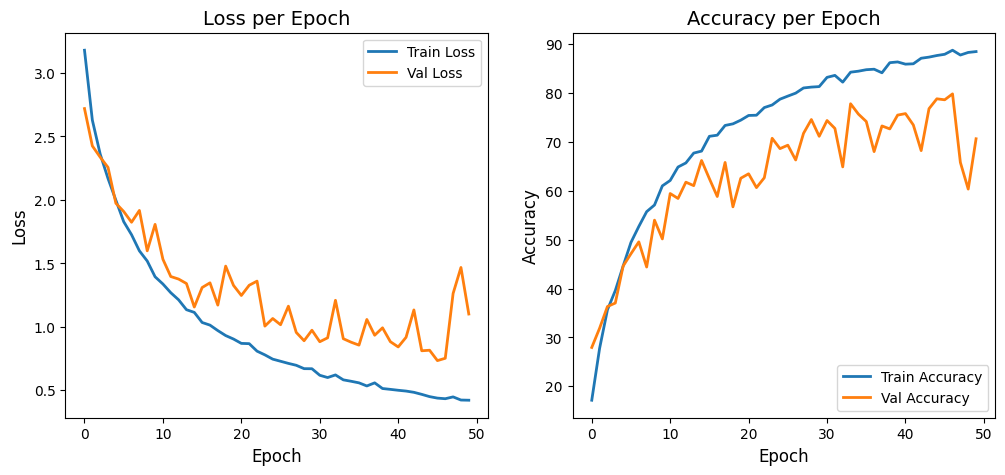

In [97]:
# обучим первую модель
opt = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)
loss_func = nn.CrossEntropyLoss()
train_model(model, 50, opt, loss_func, "first_model.pth") # поставил эпох побольше, чтобы потом прервать обучение при необходимости

In [98]:
# предсказание на тестовых данных
def form_prediction(name_of_data, model_to_predict, name_of_prediction):
    model_to_predict.eval()
    model_to_predict.load_state_dict(torch.load(name_of_data))
    all_preds = []
    filenames = []
    
    with torch.no_grad():
        for inputs, names in test_loader:
            inputs = inputs.to(device)
            outputs = model_to_predict(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            filenames.extend(names)
    
    class_names = train_dataset.classes
    class_preds = [class_names[p] for p in all_preds]
    
    results = []
    for i, (fn, pred) in enumerate(zip(filenames, class_preds)):
        class_num = int(pred.split('_')[1])
        results.append({'index': i, 'label': class_num})
    
    df = pd.DataFrame(results)
    df.to_csv(name_of_prediction, index=False)

In [99]:
# первая модель достигает порога 0.8 на валидационной выборке
# скорее всего, у нее недостаточная глубина

form_prediction("first_model.pth", model, "first_model_prediction.csv")

In [100]:
# вторая модель - дообученная b3
class ButterflyClassifier(nn.Module):
    def __init__(self): # внезапно, работает лучше без заморозки слоев, я проверял!
        super().__init__()
        self.base_model = models.efficientnet_b3(pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(self.base_model.classifier[1].in_features, 50)
        )
    
    def forward(self, x):
        return self.base_model(x)

Epoch 1/15: 100%|██████████| 248/248 [00:38<00:00,  6.44it/s]


Train Loss: 1.1588 | Acc: 71.09%
Val Loss: 0.5025 | Acc: 85.37%


Epoch 2/15: 100%|██████████| 248/248 [00:38<00:00,  6.45it/s]


Train Loss: 0.3398 | Acc: 90.24%
Val Loss: 0.4879 | Acc: 90.21%


Epoch 3/15: 100%|██████████| 248/248 [00:38<00:00,  6.43it/s]


Train Loss: 0.2500 | Acc: 92.66%
Val Loss: 0.4648 | Acc: 88.09%


Epoch 4/15: 100%|██████████| 248/248 [00:38<00:00,  6.41it/s]


Train Loss: 0.1857 | Acc: 94.70%
Val Loss: 0.3284 | Acc: 93.54%


Epoch 5/15: 100%|██████████| 248/248 [00:38<00:00,  6.42it/s]


Train Loss: 0.1047 | Acc: 96.64%
Val Loss: 0.3593 | Acc: 93.74%


Epoch 6/15: 100%|██████████| 248/248 [00:38<00:00,  6.43it/s]


Train Loss: 0.1096 | Acc: 96.92%
Val Loss: 0.4308 | Acc: 91.62%


Epoch 7/15: 100%|██████████| 248/248 [00:38<00:00,  6.45it/s]


Train Loss: 0.1181 | Acc: 96.14%
Val Loss: 0.4466 | Acc: 91.02%


Epoch 8/15: 100%|██████████| 248/248 [00:38<00:00,  6.44it/s]


Train Loss: 0.1260 | Acc: 96.17%
Val Loss: 0.6098 | Acc: 88.70%


Epoch 9/15: 100%|██████████| 248/248 [00:38<00:00,  6.44it/s]


Train Loss: 0.1212 | Acc: 96.59%
Val Loss: 0.4045 | Acc: 93.14%


Epoch 10/15: 100%|██████████| 248/248 [00:38<00:00,  6.42it/s]


Train Loss: 0.0989 | Acc: 97.15%
Val Loss: 0.4390 | Acc: 91.93%


Epoch 11/15: 100%|██████████| 248/248 [00:38<00:00,  6.38it/s]


Train Loss: 0.0773 | Acc: 97.93%
Val Loss: 0.5488 | Acc: 90.41%


Epoch 12/15: 100%|██████████| 248/248 [00:38<00:00,  6.42it/s]


Train Loss: 0.0830 | Acc: 97.70%
Val Loss: 0.4359 | Acc: 92.94%


Epoch 13/15: 100%|██████████| 248/248 [00:38<00:00,  6.42it/s]


Train Loss: 0.0639 | Acc: 98.31%
Val Loss: 0.5292 | Acc: 91.42%


Epoch 14/15: 100%|██████████| 248/248 [00:38<00:00,  6.45it/s]


Train Loss: 0.0659 | Acc: 98.16%
Val Loss: 0.4699 | Acc: 92.73%


Epoch 15/15: 100%|██████████| 248/248 [00:38<00:00,  6.43it/s]


Train Loss: 0.0858 | Acc: 97.65%
Val Loss: 0.6150 | Acc: 89.81%


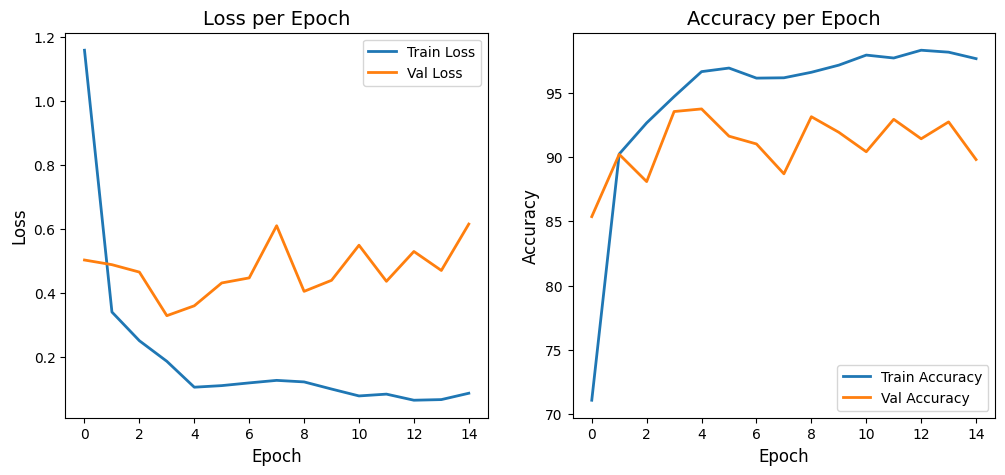

In [101]:
model = ButterflyClassifier().to(device)

loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

train_model(model, 15, opt, loss_func, "second_model.pth")

In [102]:
form_prediction("second_model.pth", model, "second_model_prediction.csv")

In [103]:
# попробуем изменить последнюю модель
class ButterflyClassifierUpdated(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.efficientnet_b3(pretrained=True)
        self.base_model.classifier = nn.Sequential( # пробовал менять последние слои, эта архитектура показала себя лучше всего
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(self.base_model.classifier[1].in_features, 50)
        )
    
    def forward(self, x):
        return self.base_model(x)

In [104]:
# добавим аугментации
aug_transform = transforms.Compose([
    transforms.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.)),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.1),
    transforms.RandomAdjustSharpness(1.5, p=0.3),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# придется заново создать датасеты
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=None
)

train_tmp, val_tmp = random_split(train_dataset, [0.95, 0.05]) # для итогового предсказания обучим на большем количестве данных

In [105]:
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_ds = TransformSubset(train_tmp, aug_transform)
val_ds = TransformSubset(val_tmp, transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

Epoch 1/30: 100%|██████████| 295/295 [01:23<00:00,  3.53it/s]


Train Loss: 3.4878 | Acc: 25.15%
Val Loss: 3.8211 | Acc: 63.16%


Epoch 2/30: 100%|██████████| 295/295 [01:20<00:00,  3.66it/s]


Train Loss: 1.7920 | Acc: 71.03%
Val Loss: 3.8185 | Acc: 78.54%


Epoch 3/30: 100%|██████████| 295/295 [01:20<00:00,  3.66it/s]


Train Loss: 0.8267 | Acc: 84.56%
Val Loss: 1.7819 | Acc: 88.66%


Epoch 4/30: 100%|██████████| 295/295 [01:19<00:00,  3.70it/s]


Train Loss: 0.5169 | Acc: 88.87%
Val Loss: 2.3145 | Acc: 90.28%


Epoch 5/30: 100%|██████████| 295/295 [01:19<00:00,  3.70it/s]


Train Loss: 0.3684 | Acc: 92.31%
Val Loss: 0.5226 | Acc: 92.71%


Epoch 6/30: 100%|██████████| 295/295 [01:20<00:00,  3.68it/s]


Train Loss: 0.2957 | Acc: 93.61%
Val Loss: 0.7537 | Acc: 93.93%


Epoch 7/30: 100%|██████████| 295/295 [01:20<00:00,  3.68it/s]


Train Loss: 0.2490 | Acc: 94.37%
Val Loss: 0.2775 | Acc: 94.74%


Epoch 8/30: 100%|██████████| 295/295 [01:19<00:00,  3.70it/s]


Train Loss: 0.2032 | Acc: 95.33%
Val Loss: 0.4606 | Acc: 93.93%


Epoch 9/30: 100%|██████████| 295/295 [01:20<00:00,  3.67it/s]


Train Loss: 0.1604 | Acc: 96.30%
Val Loss: 0.2309 | Acc: 93.93%


Epoch 10/30: 100%|██████████| 295/295 [01:19<00:00,  3.69it/s]


Train Loss: 0.1475 | Acc: 96.41%
Val Loss: 0.2235 | Acc: 95.14%


Epoch 11/30: 100%|██████████| 295/295 [01:20<00:00,  3.67it/s]


Train Loss: 0.1323 | Acc: 96.52%
Val Loss: 0.2317 | Acc: 95.55%


Epoch 12/30: 100%|██████████| 295/295 [01:20<00:00,  3.69it/s]


Train Loss: 0.1135 | Acc: 97.22%
Val Loss: 0.2323 | Acc: 95.14%


Epoch 13/30: 100%|██████████| 295/295 [01:20<00:00,  3.67it/s]


Train Loss: 0.1003 | Acc: 97.34%
Val Loss: 0.2245 | Acc: 95.95%


Epoch 14/30: 100%|██████████| 295/295 [01:20<00:00,  3.67it/s]


Train Loss: 0.0926 | Acc: 97.88%
Val Loss: 0.2376 | Acc: 95.55%


Epoch 15/30: 100%|██████████| 295/295 [01:21<00:00,  3.64it/s]


Train Loss: 0.0798 | Acc: 98.19%
Val Loss: 0.2162 | Acc: 95.95%


Epoch 16/30: 100%|██████████| 295/295 [01:21<00:00,  3.64it/s]


Train Loss: 0.0719 | Acc: 98.26%
Val Loss: 0.2345 | Acc: 95.95%


Epoch 17/30: 100%|██████████| 295/295 [01:20<00:00,  3.68it/s]


Train Loss: 0.0684 | Acc: 98.51%
Val Loss: 0.2304 | Acc: 95.14%


Epoch 18/30: 100%|██████████| 295/295 [01:19<00:00,  3.69it/s]


Train Loss: 0.0630 | Acc: 98.66%
Val Loss: 0.2400 | Acc: 96.36%


Epoch 19/30: 100%|██████████| 295/295 [01:19<00:00,  3.69it/s]


Train Loss: 0.0570 | Acc: 98.62%
Val Loss: 0.2350 | Acc: 94.74%


Epoch 20/30: 100%|██████████| 295/295 [01:21<00:00,  3.64it/s]


Train Loss: 0.0500 | Acc: 98.81%
Val Loss: 0.2488 | Acc: 95.95%


Epoch 21/30: 100%|██████████| 295/295 [01:21<00:00,  3.64it/s]


Train Loss: 0.0483 | Acc: 98.87%
Val Loss: 0.2412 | Acc: 96.36%


Epoch 22/30: 100%|██████████| 295/295 [01:20<00:00,  3.65it/s]


Train Loss: 0.0503 | Acc: 98.90%
Val Loss: 0.2548 | Acc: 96.36%


Epoch 23/30: 100%|██████████| 295/295 [01:20<00:00,  3.67it/s]


Train Loss: 0.0502 | Acc: 98.87%
Val Loss: 0.2415 | Acc: 96.36%


Epoch 24/30: 100%|██████████| 295/295 [01:19<00:00,  3.70it/s]


Train Loss: 0.0438 | Acc: 98.98%
Val Loss: 0.2471 | Acc: 95.95%


Epoch 25/30: 100%|██████████| 295/295 [01:19<00:00,  3.70it/s]


Train Loss: 0.0418 | Acc: 98.98%
Val Loss: 0.2270 | Acc: 96.36%


Epoch 26/30: 100%|██████████| 295/295 [01:20<00:00,  3.68it/s]


Train Loss: 0.0385 | Acc: 99.19%
Val Loss: 0.2477 | Acc: 96.76%


Epoch 27/30: 100%|██████████| 295/295 [01:20<00:00,  3.67it/s]


Train Loss: 0.0389 | Acc: 99.09%
Val Loss: 0.2381 | Acc: 96.76%


Epoch 28/30: 100%|██████████| 295/295 [01:20<00:00,  3.68it/s]


Train Loss: 0.0338 | Acc: 99.36%
Val Loss: 0.2376 | Acc: 96.76%


Epoch 29/30: 100%|██████████| 295/295 [01:20<00:00,  3.66it/s]


Train Loss: 0.0284 | Acc: 99.28%
Val Loss: 0.2692 | Acc: 96.36%


Epoch 30/30: 100%|██████████| 295/295 [01:20<00:00,  3.66it/s]


Train Loss: 0.0256 | Acc: 99.41%
Val Loss: 0.2866 | Acc: 95.95%


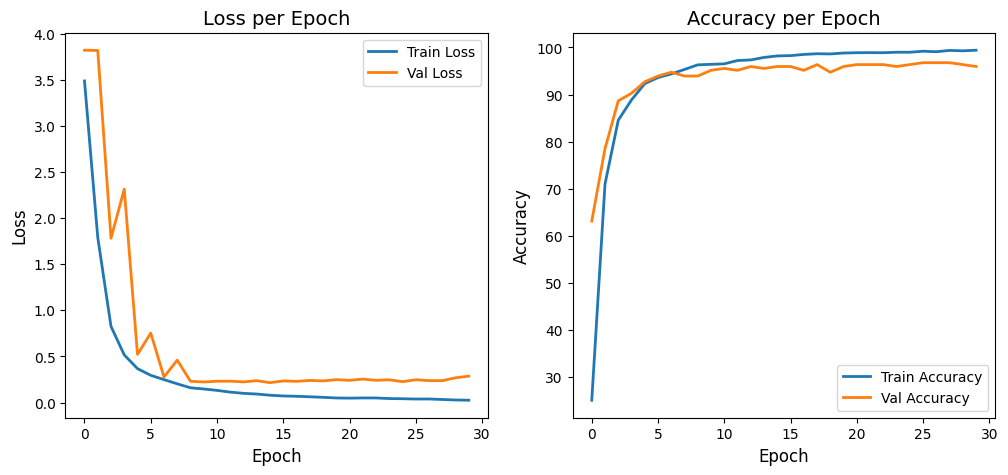

In [108]:
model = ButterflyClassifierUpdated().to(device)
opt = optim.Adam(model.parameters(), lr=0.00005, amsgrad=True) # .0001
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2) # без планировщика лучше
loss_func = nn.CrossEntropyLoss()
train_model(model, 30, opt, loss_func, "third_model.pth") # больше эпох, так как модель сложнее

In [107]:
form_prediction("third_model.pth", model, "third_model_prediction.csv")